# Dataset Creation from video

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch

In [4]:
IMAGE_SIZE = 512

In [5]:
import cv2
import os

def extract_frames(video_path, output_folder, stride=30,name_prefix=""):
    cap = cv2.VideoCapture(video_path)
    frame_nr = 0
    os.makedirs(output_folder, exist_ok=True)

    while cap.isOpened():

        success, frame = cap.read()
        if not success: break
        
        # Only save every 'stride' frames (e.g., 1 frame per second at 30fps)
        if frame_nr % stride == 0:
            cv2.imwrite(f"{output_folder}/{name_prefix}_frame_{frame_nr}.jpg", frame)
        frame_nr += 1
    cap.release()

for i in range(12):
    extract_frames(f"./Video_Folder/video_{i+1}.mp4", f"Dataset/img_video_{i+1}", stride=30,name_prefix=f"video_{i+1}")

In [11]:
Images = []
for i in range(12):
    img_folder = f"Dataset/img_video_{i+1}"
    for img_name in os.listdir(img_folder):
        Images.append(f"{img_folder}/{img_name}")

print(f"Total extracted images: {len(Images)}")
os.makedirs("Dataset/Basketball_raw_images", exist_ok=True)
for idx, img_path in enumerate(Images):
    img = cv2.imread(img_path)
    cv2.imwrite(f"Dataset/Basketball_raw_images/img_{idx+1}.jpg", img)

Total extracted images: 672


# Auto-Labelling 

In [7]:
%pip install -q rfdetr supervision==0.26.1 roboflow

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
label-studio-sdk 2.0.16 requires opencv-python-headless<5.0.0,>=4.12.0, but you have opencv-python-headless 4.10.0.84 which is incompatible.


In [9]:
%pip install autodistill_grounding_dino

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for rf-groundingdino: filename=rf_groundingdino-0.1.2-py2.py3-none-any.whl size=88876 sha256=2e3e4f05513b319dc108c863da33168279248942dd0839ed73980c5ab33da350
  Stored in directory: c:\users\baldi\appdata\local\pip\cache\wheels\a1\d4\2e\3648bc227b2c696b7fa24bbd63a83683a12c67f6a1cf07b2df
Successfully built rf-groundingdino

  Attempting uninstall: rf-groundingdino

    Found existing installation: rf_groundingdino 0.3.0

    Uninstalling rf_groundingdino-0.3.0:

      Successfully uninstalled rf_groundingdino-0.3.0

   ---------------------------------------- 0/2 [rf-groundingdino]
   ---------------------------------------- 0/2 [rf-groundingdino]


In [6]:
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology

Importing from timm.models.layers is deprecated, please import via timm.layers


## Grounding DINO

I tried to autolabel the dataset using grounding DINO first, the results has not satisfied me and I changed the base model later.

In [7]:
#Teacher Model Grounding DINO
base_model = GroundingDINO(ontology=CaptionOntology({
    "basketball player in a possession": "player_in_possession",
    "basketball player lay-up for a slam dunk": "dunk",
    "basketball player shooting a jump shot": "jump_shot",
    "basketball player": "player",
    "referee": "referee",
    "basketball": "ball",
    "basketball hoop": "rim",
    "jersey number": "jersey_number",
    "basketball in basketball hoop": "ball_in_rim",
    "basketball player blocking a shot": "player_shot_block",
}))

# 2. Auto-label your raw images
# This runs the slow Teacher model over your folder and saves labels in YOLO format
base_model.label(
    input_folder="./raw_basketball_frames",
    output_folder="./dataset_autolabeled"
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)


final text_encoder_type: bert-base-uncased


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Labeling images: 0it [00:00, ?it/s]

Labeled dataset created - ready for distillation.


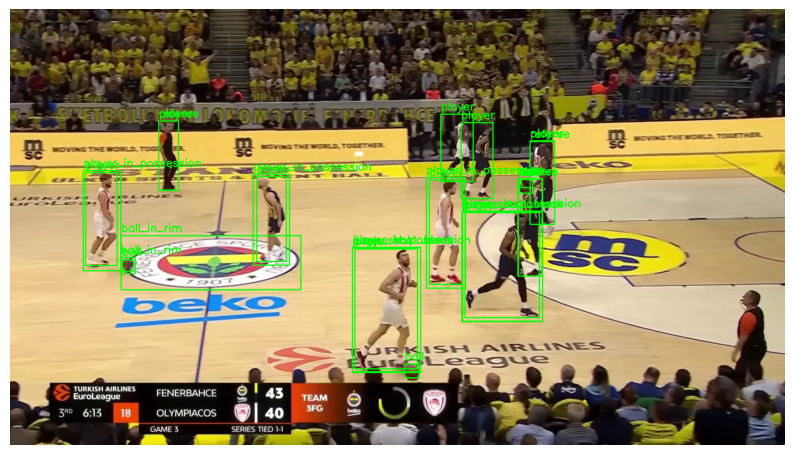

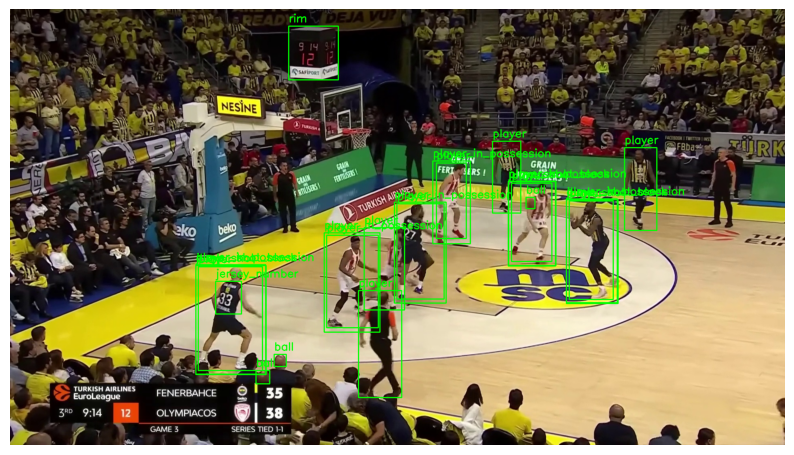

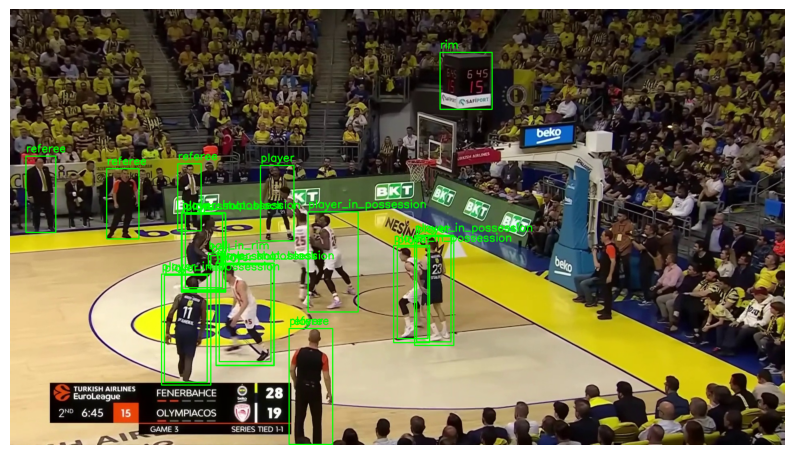

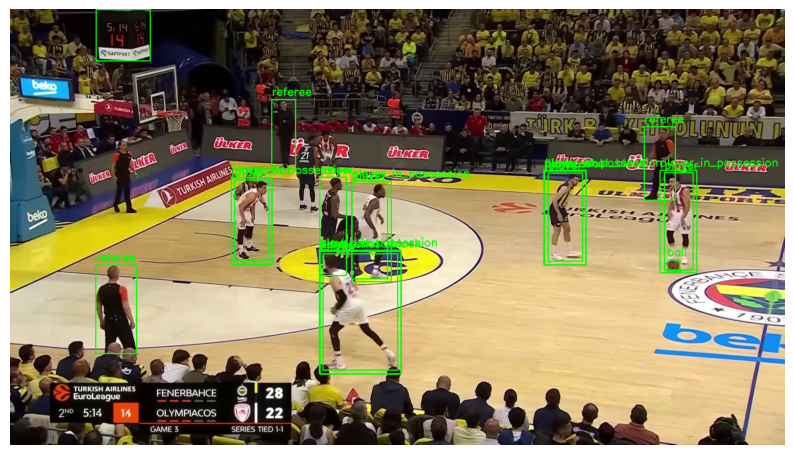

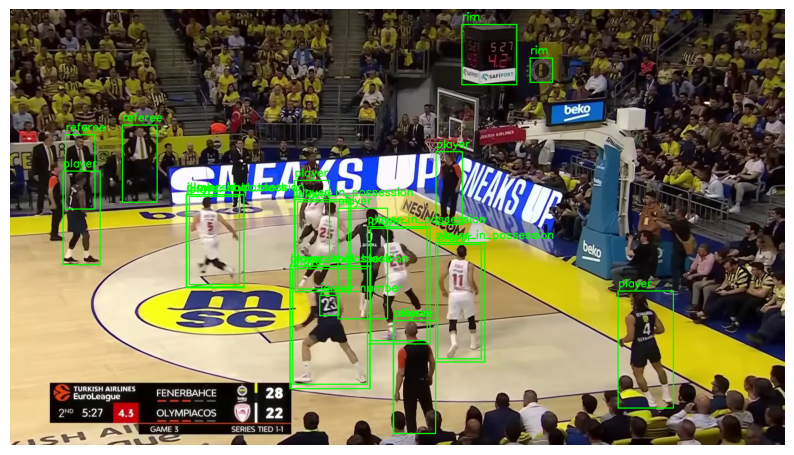

In [8]:
import cv2
import os
import matplotlib.pyplot as plt
import random

# update paths to your actual folders
IMG_DIR = r"dataset_autolabeled/train/images"
LABEL_DIR = r"dataset_autolabeled/train/labels"
CLASSES = [
    "player_in_possession", 
    "dunk", 
    "jump_shot", 
    "player", 
    "referee", 
    "ball", 
    "rim", 
    "jersey_number", 
    "ball_in_rim", 
    "player_shot_block"
]

def visualize_random_sample(num_samples=5):
    image_files = os.listdir(IMG_DIR)
    random_files = random.sample(image_files, num_samples)

    for img_file in random_files:
        if not img_file.endswith(('.jpg', '.png')): continue
        
        img_path = os.path.join(IMG_DIR, img_file)
        label_file = img_file.rsplit('.', 1)[0] + ".txt"
        label_path = os.path.join(LABEL_DIR, label_file)
        
        frame = cv2.imread(img_path)
        h, w, _ = frame.shape
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    cls_id = int(parts[0])
                    # YOLO format is normalized (0-1), convert to pixels
                    cx, cy, bw, bh = map(float, parts[1:])
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)
                    
                    # Draw box and label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, CLASSES[cls_id], (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        # Convert BGR to RGB for correct color rendering in Notebooks
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


# Uncomment to run
visualize_random_sample()

After seeing results of GroundingDINO and trying different prompt combinations I decided to use SAM3 as a teacher model for autolabeling process. 

However since my local doesn't satisfy requirements of SAM3, I made labeling on UheM Altay Cluster.

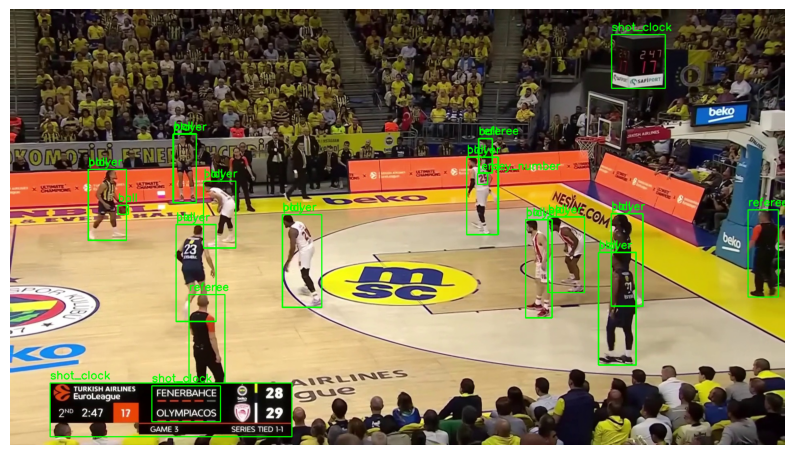

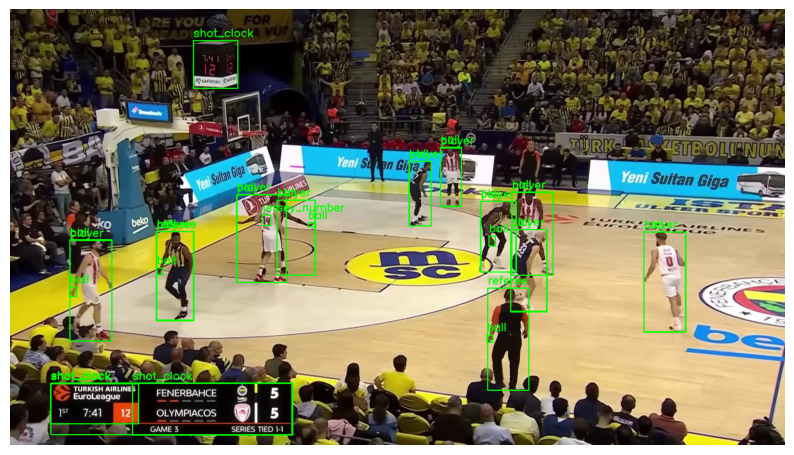

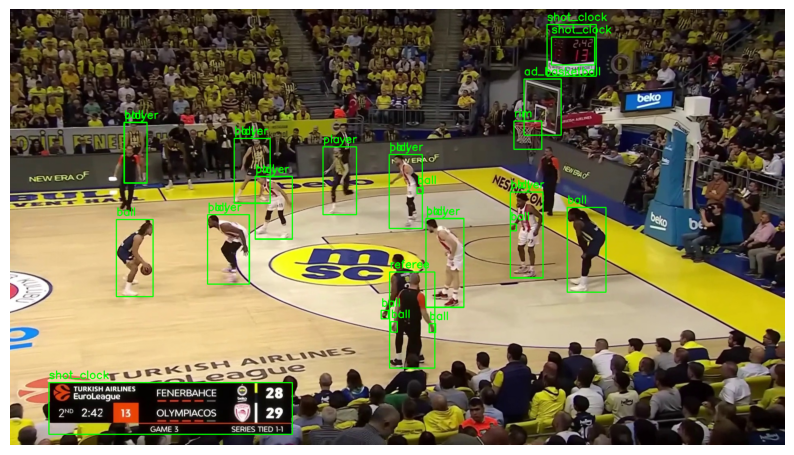

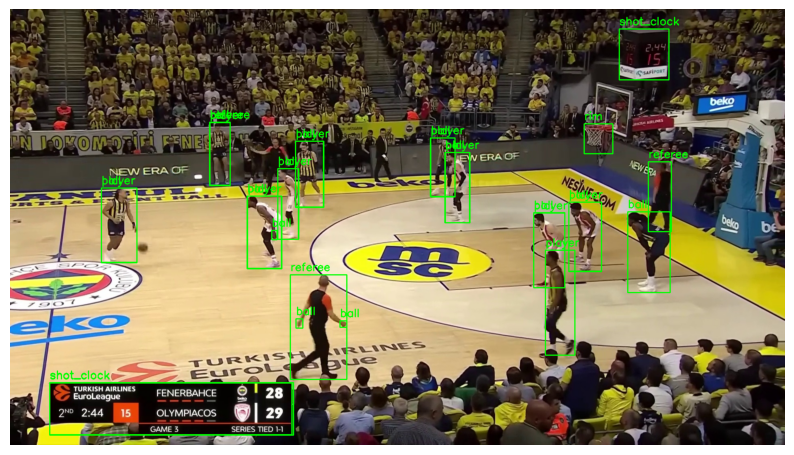

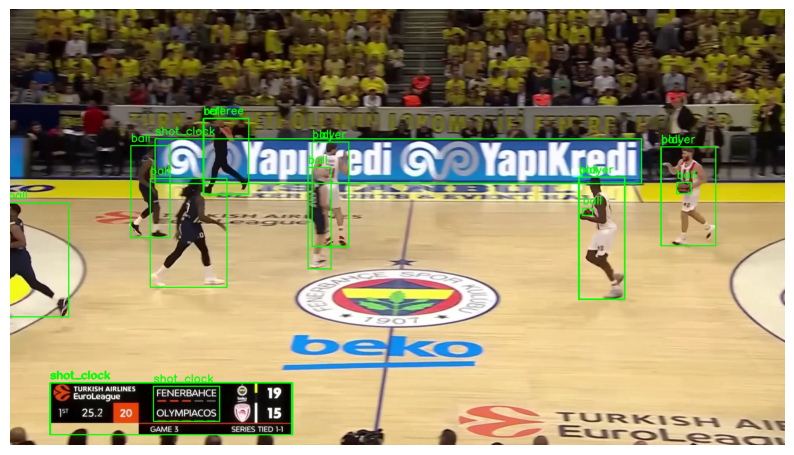

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import sys

# update paths to your actual folders
IMG_DIR = r"C:\Users\baldi\Desktop\DSAI_544\Final_Project\Dataset\Basketball_raw_images"
LABEL_DIR = r"C:\Users\baldi\Desktop\DSAI_544\Final_Project\sample_output"
CLASSES = [
    "player",
    "referee",
    "ball",
    "jersey_number",
    "rim",
    "shot_clock",
    "ad_basketball"
]
class_to_id = {
    "player": 0,
    "referee": 1,
    "ball": 2,
    "jersey_number": 3,
    "rim": 4,
    "shot_clock": 5,
    "ad_basketball": 6 
}
classes= list(class_to_id.keys())
def visualize_random_sample(num_samples=5):
    image_files = os.listdir(IMG_DIR)
    random_files = random.sample(image_files, num_samples)

    for img_file in random_files:
        if not img_file.endswith(('.jpg', '.png')): continue
        
        img_path = os.path.join(IMG_DIR, img_file)
        label_file = img_file.rsplit('.', 1)[0] + ".txt"
        label_path = os.path.join(LABEL_DIR, label_file)
        
        frame = cv2.imread(img_path)
        h, w, _ = frame.shape
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:

                    parts = line.strip().split()
                    cls_id = int(parts[0])

                    if cls_id >= len(CLASSES):
                        print(f"Invalid cls_id {cls_id} in {label_file}")
                        continue

                    # YOLO format is normalized (0-1), convert to pixels
                    cx, cy, bw, bh, score = map(float, parts[1:])
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)
                    
                    # Draw box and label
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame,str(classes[cls_id]), (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        # Convert BGR to RGB for correct color rendering in Notebooks
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


# Uncomment to run
visualize_random_sample()

The results are definitely better than results of Grounding DINO, we can manually clean the annotations to have a better quality. I tried to do that however it is little time consuming work to do and to show, so I will continue with this version.

# Finetuning


After I succesfully auto-labelling the data, I fine-tuned a yolov8m model on the UHEM Cluster.

In [ ]:
"""from ultralytics import YOLO
import wandb

# 1. Init W&B (Required for grade)
wandb.init(project="basketball-cv-final", name="yolov8m-7class-ft")

# Load Model
model = YOLO('yolov8m.pt')  # Using Medium model for balance

# Train
results = model.train(
    data=DATA_DIR,
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.01,
    name='basketball_7class_run',
    device=0
)

wandb.finish()"""


After succesfully finetuning the model we tested it on an unseen game clip.

In [ ]:
"""from ultralytics import YOLO

# Load YOUR best model
model = YOLO('runs/detect/basketball_run1/weights/best.pt')

# Run on the quarter video
model.predict(source="game_quarter.mp4", save=True, conf=0.5)"""

To see the resulting video: https://drive.google.com/file/d/1NDqli7xXe4beIIVm9NwvpIUVXVcAWkuW/view?usp=sharing

And then cleaned some of the labels, so that the resulting video is nice looking.

In [ ]:
"""import cv2
from ultralytics import YOLO
import os

# =================CONFIGURATION=================
# 1. Path to your trained weights
model_path = '/ari/users/aozturk03/YoloV8FT/runs/detect/basketball_7class_run/weights/best.pt'

# 2. Path to your input video
input_video_path = '/ari/users/aozturk03/Basketball_raw_images/sample_game.mp4'

# 3. Define which classes you want to see.
# Based on your training logs: 0=player, 1=referee.
# We only keep these two for a clean look.
CLASSES_TO_SHOW = [0, 1] 

# 4. Output settings
project_dir = '/ari/users/aozturk03/YoloV8FT/inference_output'
run_name = 'clean_demo'
# ===============================================

def run_clean_inference():
    # Ensure output directory exists to avoid errors
    os.makedirs(project_dir, exist_ok=True)

    print(f"Loading model from: {model_path}")
    model = YOLO(model_path)

    print(f"Processing video: {input_video_path}...")
    print(f"Filtering for class indices: {CLASSES_TO_SHOW}")

    # --- THE MAIN CHANGE ---
    # We use model.predict() instead of model.track().
    # This turns off the ID generation, removing the messy numbers.
    results = model.predict(
        source=input_video_path,
        save=True,              # Save the annotated video
        conf=0.5,               # Only show detections with >50% confidence
        iou=0.45,               # Standard NMS threshold
        classes=CLASSES_TO_SHOW, # <-- FILTER: Only show players and refs
        project=project_dir,
        name=run_name,
        device=0                # Ensure it runs on the GPU
    )

    print("--------------------------------------------------------")
    # The results object is a list (one item per frame for videos),
    # so we check the save_dir of the first result.
    output_folder = results[0].save_dir
    print(f"Clean video saved to: {output_folder}")
    print("You can now download this folder to view the result.")
    print("--------------------------------------------------------")

if __name__ == "__main__":
    run_clean_inference()"""

After cleaning the video, the results are as follows: https://drive.google.com/file/d/1nMjhlVvgePAF77x7ZryME0GSkpNl6j8w/view?usp=sharing